<a href="https://colab.research.google.com/github/bdrinconp/autoML/blob/main/ml_stats_classes/code_samples/clase1_introduccion_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primer modelo

Esta es un aproximación sencilla a un modelo predictivo, de regresión lineal que nos sirve de motivación para lo que viene ...

# 1. Importar librerias

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# 2. Datos

Supongamos que un analista de operaciones en un hospital desea explorar si existe una relación entre el número de personal médico disponible y el tiempo de espera que experimentan los pacientes en la sala de emergencia. En caso de que exista tal relación y se pueda establecer un modelo, esto podría ayudar a predecir el tiempo de espera y, en consecuencia, mejorar la planificación de recursos y la satisfacción del paciente.

Tenemos un conjunto de datos que cuenta con tres variables:

* Hospital: Nombre del hospital.

* Personal_Medico: Número de personal médico que ha estado disponible en el hospital durante el período de observación.

* Tiempo_Espera: Tiempo promedio de espera que experimentaron los pacientes en la sala de emergencia durante el mismo período.

In [ ]:
# Generar datos simulados
# ==============================================================================
# Establecer la semilla para reproducibilidad
np.random.seed(0)

# Generar 1000 observaciones
n = 1000

# Crear tipos de hospital
tipos_hospital = np.random.choice(['Público', 'Privado', 'Especializado'], n)

# Generar datos de personal médico y tiempo de espera según el tipo de hospital
personal_medico = np.where(tipos_hospital == 'Público', np.random.randint(20, 100, n),
                           np.where(tipos_hospital == 'Privado', np.random.randint(30, 80, n),
                                    np.random.randint(10, 50, n)))  # Especializado

error = np.random.normal(0, 10, n)  # Error aleatorio

# Suponiendo una relación lineal diferente para cada tipo de hospital
tiempo_espera = np.where(tipos_hospital == 'Público', 180 - 1.65 * personal_medico + error,
                         np.where(tipos_hospital == 'Privado', 130 - 1.2 * personal_medico + error,
                                  150 - 2 * personal_medico + error))  # Especializado

In [ ]:
# Crear un DataFrame
# ==============================================================================
datos = pd.DataFrame({'Tipo_Hospital': tipos_hospital, 'Personal_Medico': personal_medico, 'Tiempo_Espera': tiempo_espera})

# Generar los nombres de los hospitales
nombres_hospitales = ['Hospital {}'.format(i + 1) for i in range(n)]
datos['Hospital'] = nombres_hospitales

datos


,Tipo_Hospital,Personal_Medico,Tiempo_Espera,Hospital
0,Público,77,51.712338,Hospital 1
1,Privado,65,44.016239,Hospital 2
2,Público,75,62.548145,Hospital 3
3,Privado,58,61.783479,Hospital 4
4,Privado,77,31.479559,Hospital 5
...,...,...,...,...
995,Especializado,29,88.515432,Hospital 996
996,Privado,40,100.869187,Hospital 997
997,Público,93,12.322149,Hospital 998
998,Especializado,13,124.882637,Hospital 999


# 3. Análisis exploratorio

El primer paso antes de generar un modelo de regresión LINEAL es representar los datos para poder intuir si existe una relación y cuantificar dicha relación mediante un coeficiente de correlación.


In [ ]:
# Estadísticas descriptivas
# ==============================================================================
estadisticas_detalladas = datos.groupby('Tipo_Hospital').agg({
    'Personal_Medico': ['mean', 'std', 'min', 'max'],
    'Tiempo_Espera': ['mean', 'std', 'min', 'max']
})

estadisticas_detalladas

Personal_Medico                    Tiempo_Espera             \
                         mean        std min max          mean        std   
Tipo_Hospital                                                               
Especializado       29.853659  12.206803  10  49     90.753973  26.580278   
Privado             54.056716  15.037869  30  79     64.284637  19.676368   
Público             57.780415  22.772801  21  99     84.068173  38.797027   

                                      
                     min         max  
Tipo_Hospital                         
Especializado  35.057409  149.906794  
Privado        23.005830  111.790768  
Público         0.725529  172.481516

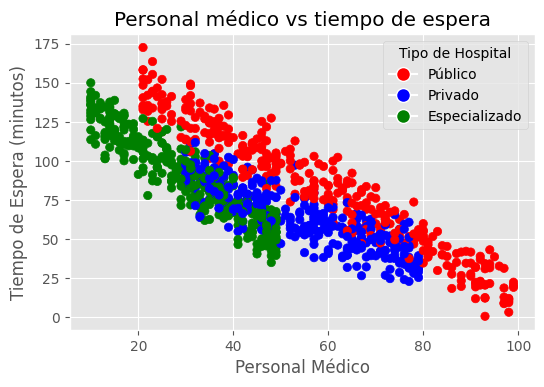

In [ ]:
# Gráfico
# ==============================================================================
color_map = {
    'Público': 'red',
    'Privado': 'blue',
    'Especializado': 'green'
}
colores = datos['Tipo_Hospital'].map(color_map)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.scatter(datos['Personal_Medico'], datos['Tiempo_Espera'], c=colores, label=colores)
ax.set_title('Personal médico vs tiempo de espera')
ax.set_xlabel('Personal Médico')
ax.set_ylabel('Tiempo de Espera (minutos)')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[key], markersize=10, label=key) for key in color_map]
ax.legend(handles=legend_elements, title='Tipo de Hospital')

plt.show()

Es importante tener en cuenta, que el objetivo del analista es establecer una relación (y posible modelo) para determinar el tiempo de espera en función del número de personal médico disponible, por este motivo el personal médico se ubica en el eje X y el tiempo de espera en el eje Y del gráfico.

En este caso, el personal médico funciona como variable independiente (eje X), y el tiempo de espera como variable dependiente (eje Y).

Esto se puede representar matemáticamente como:

$$Tiempo \ Espera = f(Personal \ Medico)$$

Esta representación matemática sugiere que el tiempo de espera podría ser modelado o explicado en función del número de personal médico disponible, lo que puede proporcionar insights valiosos para la gestión operativa del hospital.

Un indicativo de una posible relación (lineal) puede ser el coeficiente de correlación de Pearson, esta medica nos dice qué tan fuerte y qué dirección está la relación lineal entre dos variables. El valor de este coefiente va de -1 a 1.

* Un valor cercano a 1 indica una fuerte correlación positiva: cuando una variable aumenta, la otra también tiende a aumentar.

* Un valor cercano a -1 indica una fuerte correlación negativa: cuando una variable aumenta, la otra tiende a disminuir.

* Un valor cercano a 0 sugiere que no hay una relación lineal clara entre las variables.

In [ ]:
corr_test = pearsonr(x = datos['Personal_Medico'], y =  datos['Tiempo_Espera'])
print("Coeficiente de correlación de Pearson: ", corr_test[0])
print("P-value: ", corr_test[1])

Coeficiente de correlación de Pearson:  -0.8282151839854952
P-value:  3.11139357982876e-253


El gráfico y el test de correlación muestran una relación lineal, de intensidad considerable (r = -0.963). Por lo cual tiene sentido intentar generar un modelo de regresión lineal con el objetivo de predecir el tiempo promedio de espera en función del número de personal medico disponible.

Un P-value bajo (generalmente menor a 0.05) nos ayuda a reforzar la idea de que la correlación observada en los datos es similar a la "real".

# 4. Ajuste del primer modelo

Vamos a construir un modelo de regresión lineal simple, formalmente expresado como:

$$ Tiempo \ Espera = \hat{\beta_0} + \hat{\beta_1} * Personal Medico $$

Anteriormente establecimos la intención de predecir las carreras en función de los bateos. Esto lo expresamos matemáticamente como:

$$ Tiempo \ Espera = f(Personal \ Medico)$$

Ahora, después de identificar que existe una relación lineal entre el número de personal médico y el tiempo de espera a través de análisis previos, podemos concluir que un buen candidato para nuestra función $f$ podria tomar una forma lineal. Esto significa que la función $f$ queda definida por los parámetros $\hat{\beta_0}$ y $\hat{\beta_1}$, que corresponden al intercepto y la pendiente de la línea, respectivamente.

In [ ]:
# Preparamos los datos para el modelo/modelos, para esto codificar la variable categórica
# ==============================================================================
datos_dummies = pd.get_dummies(datos, columns=['Tipo_Hospital'], drop_first=True)
datos_dummies

,Personal_Medico,Tiempo_Espera,Hospital,Tipo_Hospital_Privado,Tipo_Hospital_Público
0,77,51.712338,Hospital 1,0,1
1,65,44.016239,Hospital 2,1,0
2,75,62.548145,Hospital 3,0,1
3,58,61.783479,Hospital 4,1,0
4,77,31.479559,Hospital 5,1,0
...,...,...,...,...,...
995,29,88.515432,Hospital 996,0,0
996,40,100.869187,Hospital 997,1,0
997,93,12.322149,Hospital 998,0,1
998,13,124.882637,Hospital 999,0,0


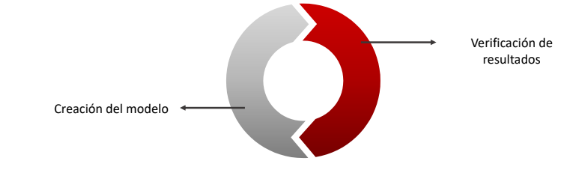

IMPORTANTE!!!!! 😀   
**train size: Tamaño de la muestra que vamos a usar para crear el modelo**

**1 - train size: Tamaño de la muestra con la cual vamos a validar los resultados del modelo**

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = datos[['Personal_Medico']]
y = datos['Tiempo_Espera']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8, # TRAIN SIZE
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train.reshape(-1, 1), y = y_train)

LinearRegression()

In [ ]:
# Información del modelo
# ==============================================================================
print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", modelo.score(X, y))

Intercept: [139.22165677]
Coeficiente: [('Personal_Medico', -1.2467823446354664)]
Coeficiente de determinación R^2: 0.6855186607805998


Con base en lo anterior nuestro modelo puede escribirse como:

$$Tiempo \ Espera = 200.937 - 1.483*Personal \ Medico $$

## 5. Predicciones

In [ ]:
# Predicciones
# ==============================================================================
# Hacer predicciones
predicciones_train = modelo.predict(X_train)


df_resultados_train = pd.DataFrame({
    'Variable_Explicativa': X_train.ravel(),
    'Predicciones': predicciones_train.ravel()
})

df_resultados_train.head()
print(df_resultados_train.shape)

(800, 2)


In [ ]:
# Predicciones
# ==============================================================================
# Hacer predicciones
predicciones_test = modelo.predict(X_test)


df_resultados_test = pd.DataFrame({
    'Variable_Explicativa': X_test.ravel(),
    'Predicciones': predicciones_test.ravel()
})

df_resultados_test.head()
print(df_resultados_test.shape)

(200, 2)


## 6. Representación gráfica del modelo

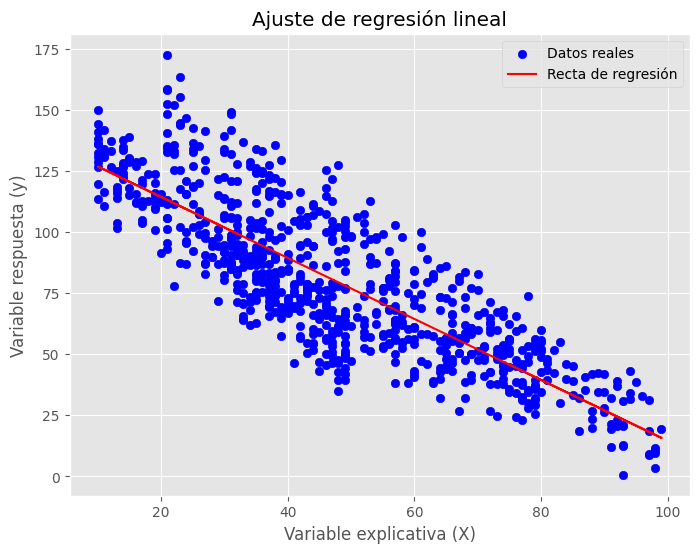

In [ ]:
# Graficar modelo con datos train
# ==============================================================================
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Datos reales')
plt.plot(X_train, predicciones_train, color='red', label='Recta de regresión')
plt.xlabel('Variable explicativa (X)')
plt.ylabel('Variable respuesta (y)')
plt.title('Ajuste de regresión lineal')
plt.legend()
plt.show()

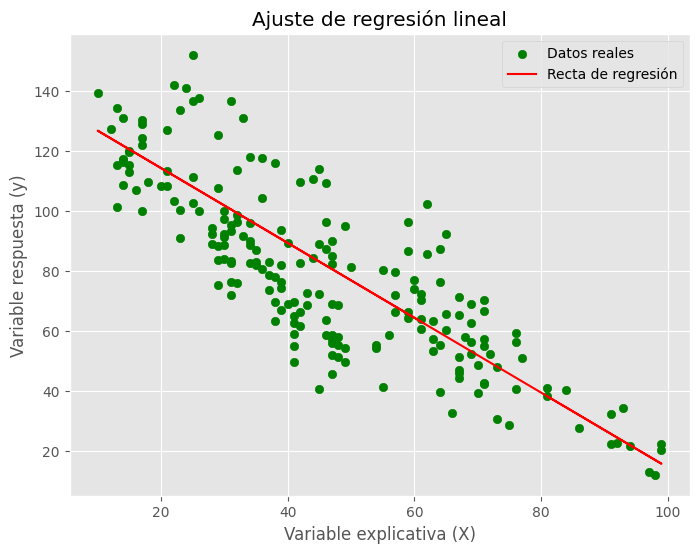

In [ ]:
# Graficar modelo con datos test
# ==============================================================================
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='green', label='Datos reales')
plt.plot(X_test, predicciones_test, color='red', label='Recta de regresión')
plt.xlabel('Variable explicativa (X)')
plt.ylabel('Variable respuesta (y)')
plt.title('Ajuste de regresión lineal')
plt.legend()
plt.show()

## 7. Error de test

In [ ]:
# Calcular el RMSE
# ==============================================================================
predicciones = modelo.predict(X_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print(f"El error (RMSE) de test es: {rmse}")

El error (RMSE) de test es: 16.788719476873172


El modelo tiene un error promedio de 11.768 minutos en sus predicciones.

# RETO 😺


Vamos a crear un modelo que no solo tenga en cuenta el personal medico, seria interesante tener en cuenta el tipo de hospital.

In [ ]:
# División de los datos en train y test
# ==============================================================================
X2 = datos_dummies[['Personal_Medico', 'Tipo_Hospital_Privado', 'Tipo_Hospital_Público']]
y2 = datos_dummies['Tiempo_Espera']

# División de los datos
# ==============================================================================
X_train2, X_test2, y_train2, y_test2 = train_test_split(
                                        X2,
                                        y2,
                                        train_size   = 0.8,  # tamaño del conjunto de entrenamiento
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación y ajuste del modelo
# ==============================================================================
modelo2 = LinearRegression()
modelo2.fit(X = X_train2, y = y_train2)

LinearRegression()

In [ ]:
# Información del modelo
# ==============================================================================
print("Intercept:", modelo2.intercept_)
print("Coeficientes:", list(zip(X2.columns, modelo2.coef_)))
print("Coeficiente de determinación R^2:", modelo2.score(X2, y2))

Intercept: 138.31164646096437
Coeficientes: [('Personal_Medico', -1.5839267724347663), ('Tipo_Hospital_Privado', 11.364853490359437), ('Tipo_Hospital_Público', 37.50650650011622)]
Coeficiente de determinación R^2: 0.8763460502384268


In [ ]:
# Calcular el RMSE
# ==============================================================================
predicciones_m2 = modelo2.predict(X_test2)
rmse_m2 = mean_squared_error(y_true=y_test2, y_pred=predicciones_m2, squared=False)
print(f"El error (RMSE) de test es: {rmse_m2}")

El error (RMSE) de test es: 11.161556764148495


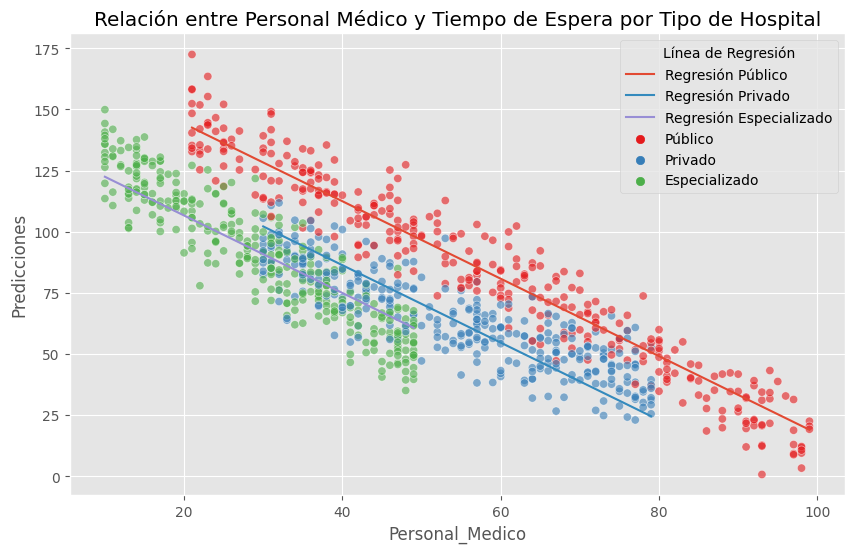

In [ ]:
# Visualizamos el modelo
# ==============================================================================
# Crear una columna para el tipo de hospital a partir de las columnas dummy
datos_dummies['Tipo_Hospital'] = np.where(datos_dummies['Tipo_Hospital_Privado'] == 1, 'Privado',
                                          np.where(datos_dummies['Tipo_Hospital_Público'] == 1, 'Público', 'Especializado'))

# Crear un DataFrame para cada tipo de hospital
datos_publico = datos_dummies[datos_dummies['Tipo_Hospital'] == 'Público'].copy()
datos_privado = datos_dummies[datos_dummies['Tipo_Hospital'] == 'Privado'].copy()
datos_especializado = datos_dummies[datos_dummies['Tipo_Hospital'] == 'Especializado'].copy()

# Calcular las predicciones para cada tipo de hospital
for df, tipo in zip([datos_publico, datos_privado, datos_especializado], ['Público', 'Privado', 'Especializado']):
    df['Predicciones'] = modelo2.predict(df[['Personal_Medico', 'Tipo_Hospital_Privado', 'Tipo_Hospital_Público']])

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar las predicciones para cada tipo de hospital
for df, tipo in zip([datos_publico, datos_privado, datos_especializado], ['Público', 'Privado', 'Especializado']):
    sns.lineplot(data=df, x='Personal_Medico', y='Predicciones', label=f'Regresión {tipo}')

# Graficar los puntos de datos originales
sns.scatterplot(data=datos_dummies, x='Personal_Medico', y='Tiempo_Espera', hue='Tipo_Hospital', palette='Set1', alpha=0.6)

plt.title('Relación entre Personal Médico y Tiempo de Espera por Tipo de Hospital')
plt.legend(title='Línea de Regresión')
plt.show()
